In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import umap
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.metrics import (
    mean_squared_error,
    r2_score,
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    confusion_matrix,
)
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sentence_transformers import SentenceTransformer
from textblob import TextBlob

/home/sunshine/anaconda3/envs/resume/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# hyperparameters/inputs/constants
SEED = 0
INPUT_FILE = "./askscience_data.csv"

The goal is to assess my ability to:
1. solve problems
2. learn new technologies

Given that we're looking to fill an LLM-focused role, I will use the `r/askreddit` dataset.

## The Approach

This is meant to be a quick project, which means the project should mostly utilize basic techniques, so I will be fairly basic with a little more sophisticated approach here and there.

Problem Statement:

Given a set of features including title and body, we would like to:

1. Determine the attributes of a successful post
2. predict the score of an `r/askscience` post. This means this problem is fundamentally a **regression** problem with a combination of structured and unstructured (textual) features.

I'm going to go through requirements, since this is a takehome I will choose intuitive answers to what would normally be questions for stakeholders.

requirements:
- It's safe to assume that a scoring model should use *a priori* features to be useful
- I'll assume there aren't any relevant constraints on compute or efficiency for the model.
- To limit work, I'm *not* going to scrape for additional data, but I will make use of PRAW to test the model on real world data.

assumptions:

- *tags are not a good modeling feature as they may not be accurately reflected in real-time data*
- *upvote ratio is not a good modeling indicator as it may not be accurately reflected in real-time data*

I don't know for sure, but I don't have data to verify these.

### Data Analysis

The first step for any good data science is EDA

In [3]:
full_df = pd.read_csv(
    INPUT_FILE,
    index_col=0,
    dtype={
        "title": str,
        "body": str,
        "tag": str,
        "author": str,
        "score": int,
        "upvote_ratio": float,
        "url": str,
    },
    parse_dates=["datetime"],
)

In [4]:
# check missing data
full_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 4205 entries, 0 to 799
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   title         4205 non-null   object        
 1   body          2492 non-null   object        
 2   tag           4011 non-null   object        
 3   datetime      4205 non-null   datetime64[ns]
 4   author        4205 non-null   object        
 5   score         4205 non-null   int64         
 6   upvote_ratio  4205 non-null   float64       
 7   url           4205 non-null   object        
dtypes: datetime64[ns](1), float64(1), int64(1), object(5)
memory usage: 295.7+ KB


In [5]:
full_df.describe()

,datetime,score,upvote_ratio
count,4205,4205.000000,4205.000000
mean,2019-11-15 13:31:33.268965632,3730.471106,0.765719
min,2010-10-29 12:18:12,0.000000,0.170000
25%,2018-01-11 04:47:32,4.000000,0.590000
50%,2020-10-31 19:41:48,35.000000,0.840000
75%,2022-02-27 08:43:02,7472.000000,0.920000
max,2022-12-09 13:06:01,83382.000000,1.000000
std,NaN,5577.606541,0.177537


## Deeper Dive Into Features

Now let's start going through the features to understand their relationship with post popularity.

In [6]:
# perform a train/test split
df, test_df = train_test_split(full_df, test_size=0.2, random_state=SEED)

In [7]:
# are there duplicates?
len(df["title"]) - df["title"].nunique()

315

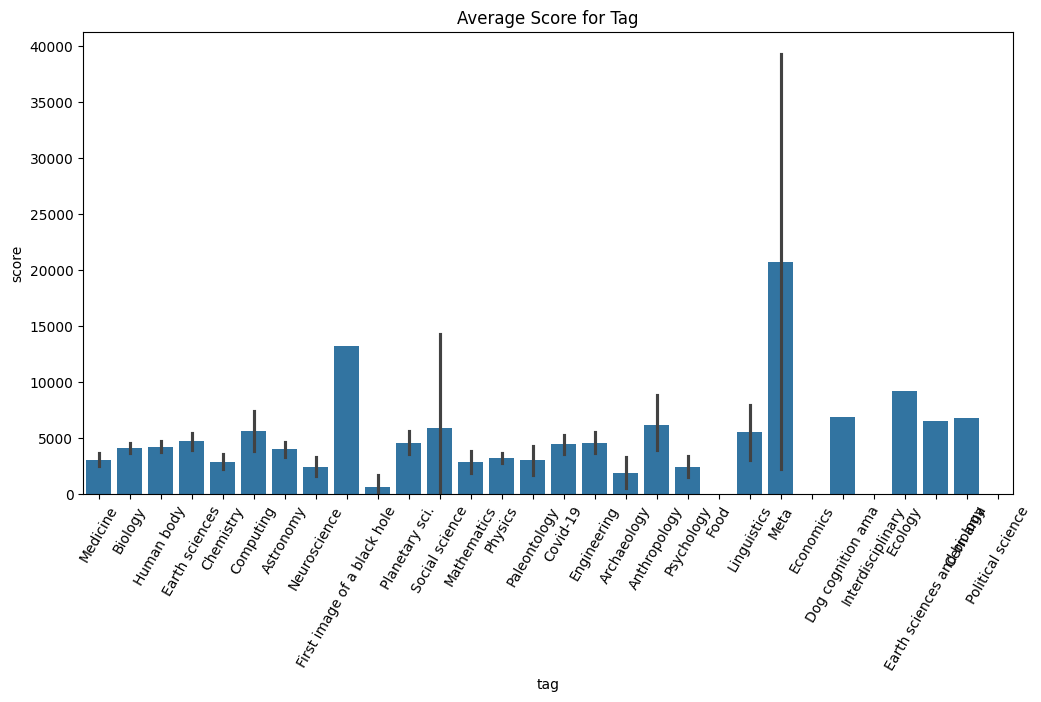

In [8]:
# how do tags relate to post popularity? They are still very valuable in EDA, even if we might not use them to model
num_tags = 20

df.tag = df.tag.fillna("").str.strip().str.capitalize()
plt.figure(figsize=(12, 6))
sns.barplot(x="tag", y="score", data=df)
plt.xticks(rotation=60)
plt.title(f"Average Score for Tag")
plt.show()

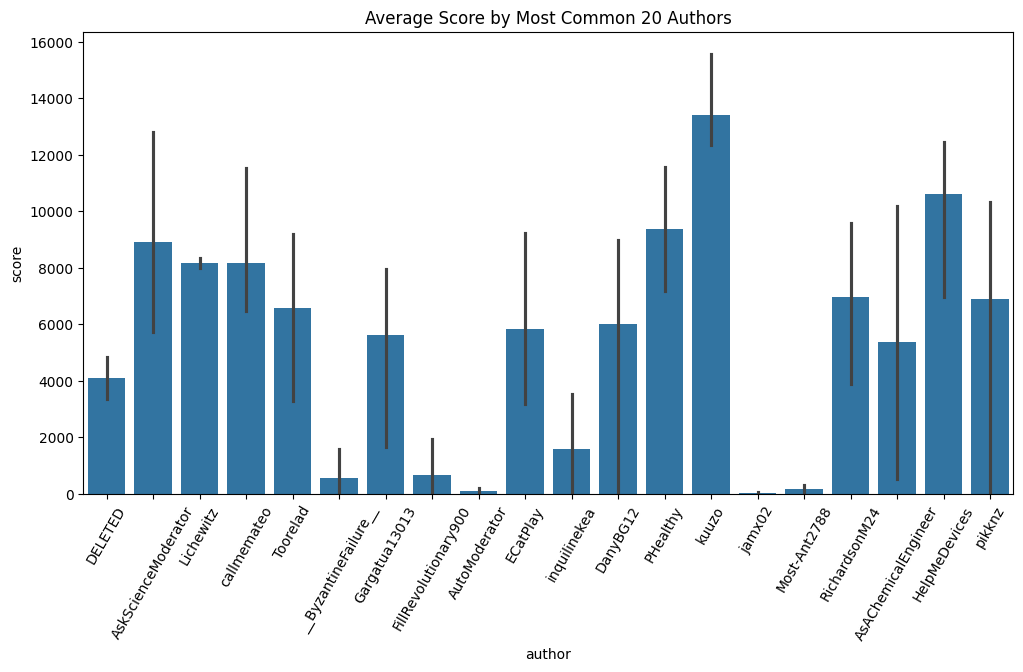

In [9]:
# how does the author relate to post popularity?
num_authors = 20

plt.figure(figsize=(12, 6))
top_authors = df["author"].value_counts().head(num_authors).index
top_authors_df = df[df["author"].isin(top_authors)]
sns.barplot(x="author", y="score", data=top_authors_df)
plt.xticks(rotation=60)
plt.title(f"Average Score by Most Common {num_authors} Authors")
plt.show()

## Time

Time is an interesting variable for modeling.  When considering dates, we have year, month, day, hour, and all of these could have implications on post popularity.

\* The raw data does not disclose the timezone of the datetime, it is probably UTC but I won't bother transforming it to a United States timezone since I do not know the true timezone.

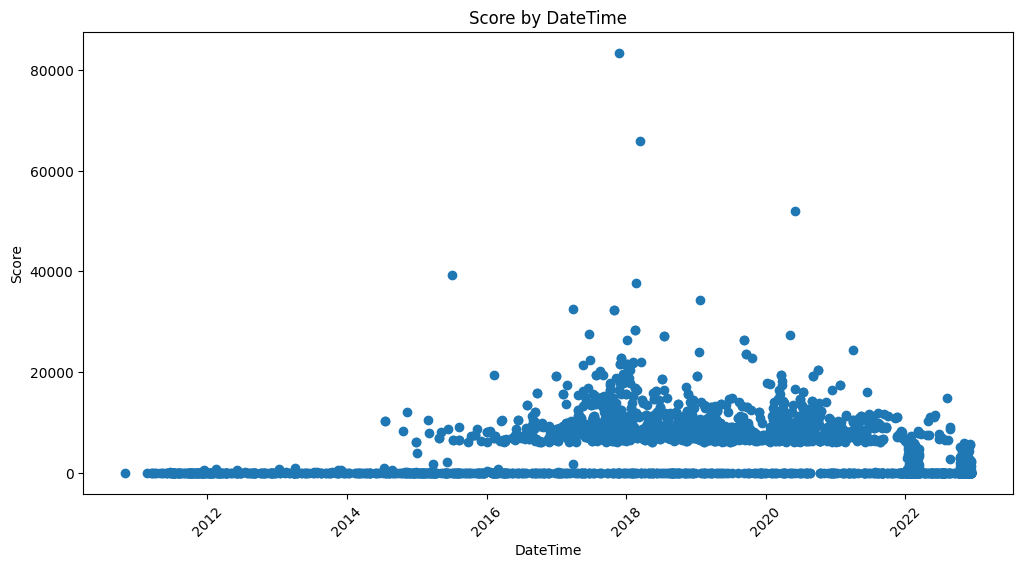

In [10]:
plt.figure(figsize=(12, 6))
plt.scatter(df["datetime"], df["score"])
plt.title("Score by DateTime")
plt.xlabel("DateTime")
plt.ylabel("Score")
plt.xticks(rotation=45)
plt.show()

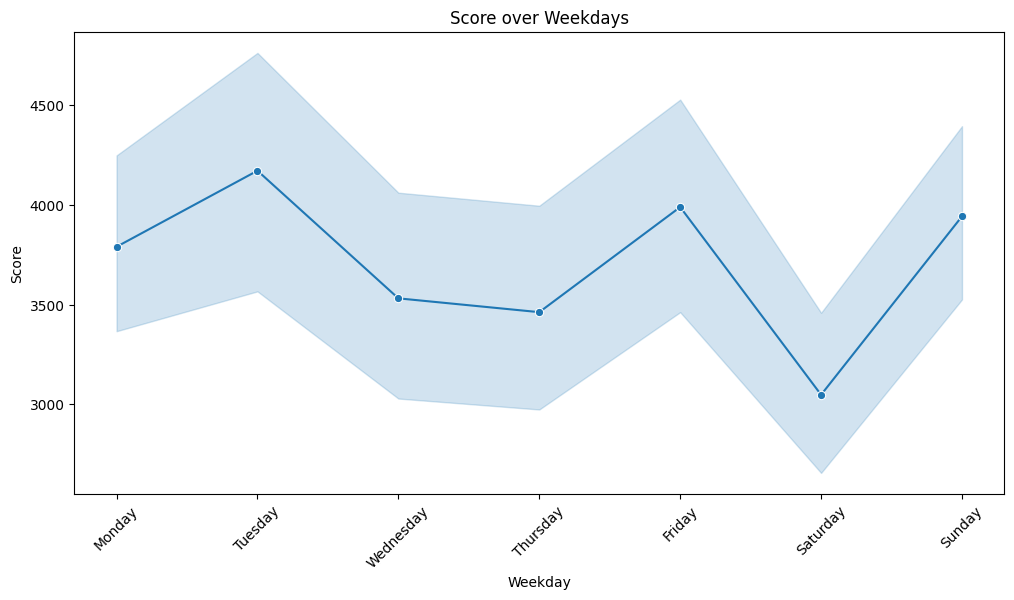

In [11]:
# Extract weekday name and create an ordered category for weekdays
def time_breakdown(df):

    df["weekday"] = df["datetime"].dt.day_name()
    weekday_order = [
        "Monday",
        "Tuesday",
        "Wednesday",
        "Thursday",
        "Friday",
        "Saturday",
        "Sunday",
    ]
    df["weekday"] = pd.Categorical(
        df["weekday"], categories=weekday_order, ordered=True
    )
    df["hour"] = df["datetime"].dt.strftime("%H")


time_breakdown(df)

# Sort the DataFrame by weekday
df = df.sort_values(by="weekday")

# Plot
plt.figure(figsize=(12, 6))
sns.lineplot(x="weekday", y="score", data=df, marker="o")
plt.xticks(rotation=45)

plt.title("Score over Weekdays")
plt.xlabel("Weekday")
plt.ylabel("Score")
plt.show()

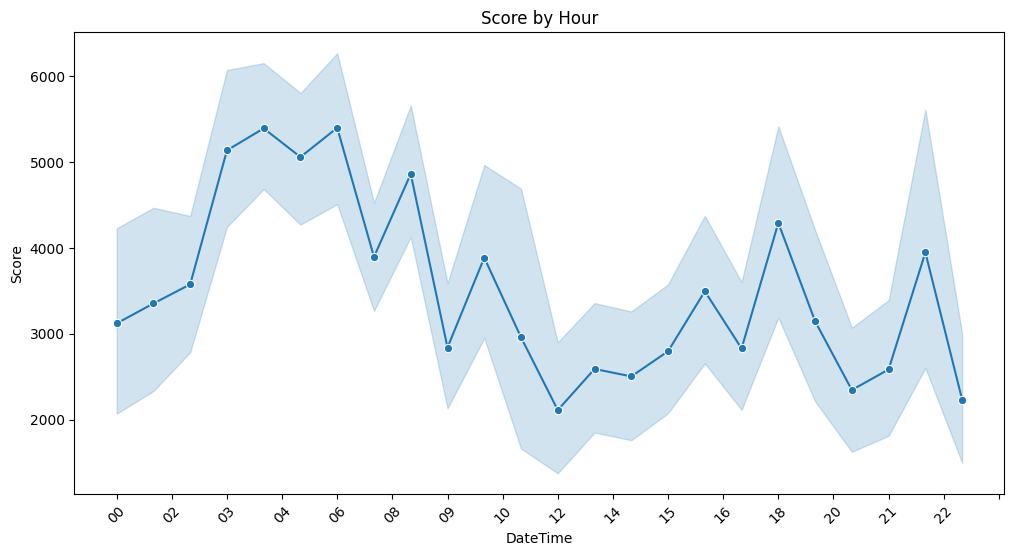

In [12]:
# create a sorted dataframe
df = df.sort_values(by="hour")

plt.figure(figsize=(12, 6))
sns.lineplot(x="hour", y="score", data=df, marker="o")
plt.title("Score by Hour")
plt.xlabel("DateTime")
plt.ylabel("Score")
plt.xticks(rotation=45)
# Put 24 ticks on the x axis
ax = plt.gca()
ax.xaxis.set_major_locator(plt.MaxNLocator(24))
plt.show()

## Observations From Analysis

### Time
- posts between 2am to 9am (again, likely UTC?) generally have higher scores
- weekday has a smaller impact on score, but still Sunday/Tuesday/Friday are somewhat higher

### Authors
- There are a number of power users who regularly have higher scores
- Moderator posts tend to be very high

### Tags
- Tags obviously have a major impact but we'll need to dive into this a little further for more insight

## What is a Successful Post?

It's clear from the DateTime plots (particularly, Score by DateTime) that the scores are bimodal.  This gives us a good measure for successful posts.

**Let's define 'successful' using this underlying bimodal nature of score.**

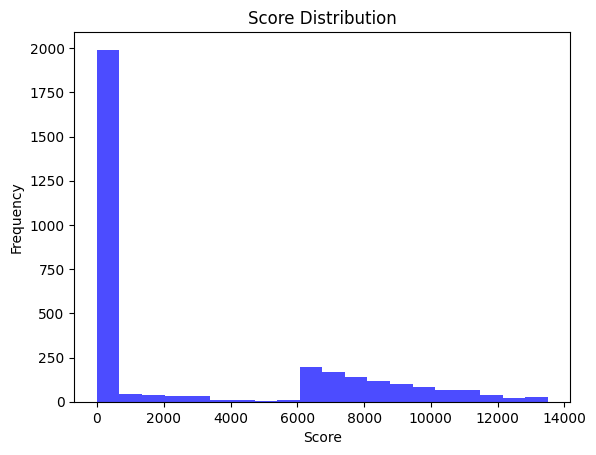

In [13]:
# Plot the histogram to visualize the bimodal distribution

# remove the heavily skewed tail first for better bins
scores = df["score"][df["score"] < np.quantile(df["score"], 0.95)]

plt.hist(scores, bins=20, alpha=0.7, color="blue")
plt.title("Score Distribution")
plt.xlabel("Score")
plt.ylabel("Frequency")
plt.show()

In [14]:
# Create successful variable based on the plot above
threshold = 6000
df["success"] = df["score"] >= threshold

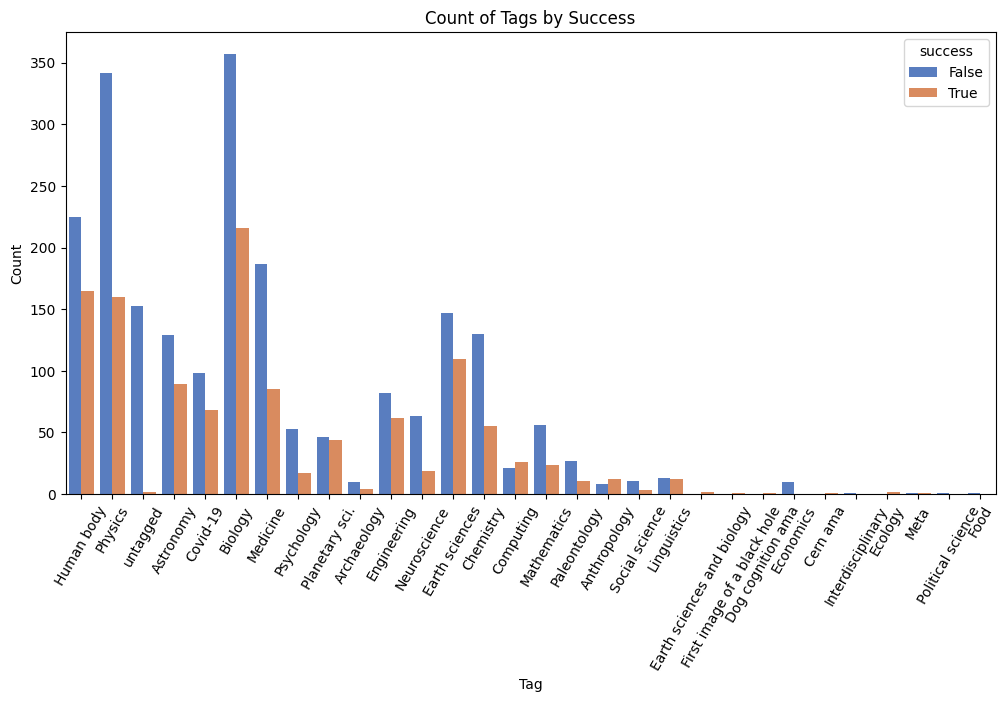

In [15]:
# let's look back at tags to see what's interesting
df["tag"] = df["tag"].replace("", "untagged")
plt.figure(figsize=(12, 6))
sns.countplot(data=df, x="tag", hue="success", palette="muted")
plt.title("Count of Tags by Success")
plt.xlabel("Tag")
plt.xticks(rotation=60)
plt.ylabel("Count")
plt.show()

Awesome!  So we can see some topics are much more common, and some are much more interesting.  Computing is even more likely than not to be successful in this dataset.

**Critically though, untagged is a major indicator that something is not going to be successful.  This unfortunately will mean it may cause bias in practice where a post might lack a tag before it is popular** 


## Diving into the unstructured data

Now that we've defined a good target for what represents a "successful post", let's take a deeper dive into 'title' and 'body' equipped with this success metric.

In order to do regression on this unstructured data, we're going to want to do some feature extraction/engineering

Now, this is where I could spend *a lot of time*, but I've already done a fair amount of work and we need to deliver a model in a matter of hours.  We'll use some pretrained models for feature extraction and see how well we can classify successful posts based on these.

### Basic Text Statistics

There's a lot of low hanging fruit for features here, the word count, word length, if the body contains text all might influence success of a post

### Topic Modeling

Obviously, tags would be very valuable.  We could use it as a model input and be done, however:

1. tag data may not be present in real world applications (i.e. predicting a new untagged post's success)
2. I want to do something a little more interesting and make use of state-of-the-art techniques.

So we'll make use of an embeddings model to embed the title of a post and create some interesting features

### Sentiment Analysis

social media posts often have sentiments which can predict engagement/reactions.  With askscience, this might not be as effective, but it's still worth exploring.  We'll use a packaged model called textblob for this.

In [16]:
def get_textual_stats(df):
    # grab some basic stats
    df["clean_title"] = df["title"].str.strip()
    df["clean_body"] = df["body"].fillna("").str.strip()
    df["title_word_count"] = df["clean_title"].apply(lambda x: len(x.split()))
    df["body_word_count"] = df["clean_body"].apply(lambda x: len(x.split()))
    df["title_avg_word_length"] = df["clean_title"].apply(
        lambda x: np.mean([len(word) for word in x.split()]) if x else 0
    )
    df["body_avg_word_length"] = df["clean_body"].apply(
        lambda x: np.mean([len(word) for word in x.split()]) if x else 0
    )


get_textual_stats(df)

/home/sunshine/anaconda3/envs/resume/lib/python3.11/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


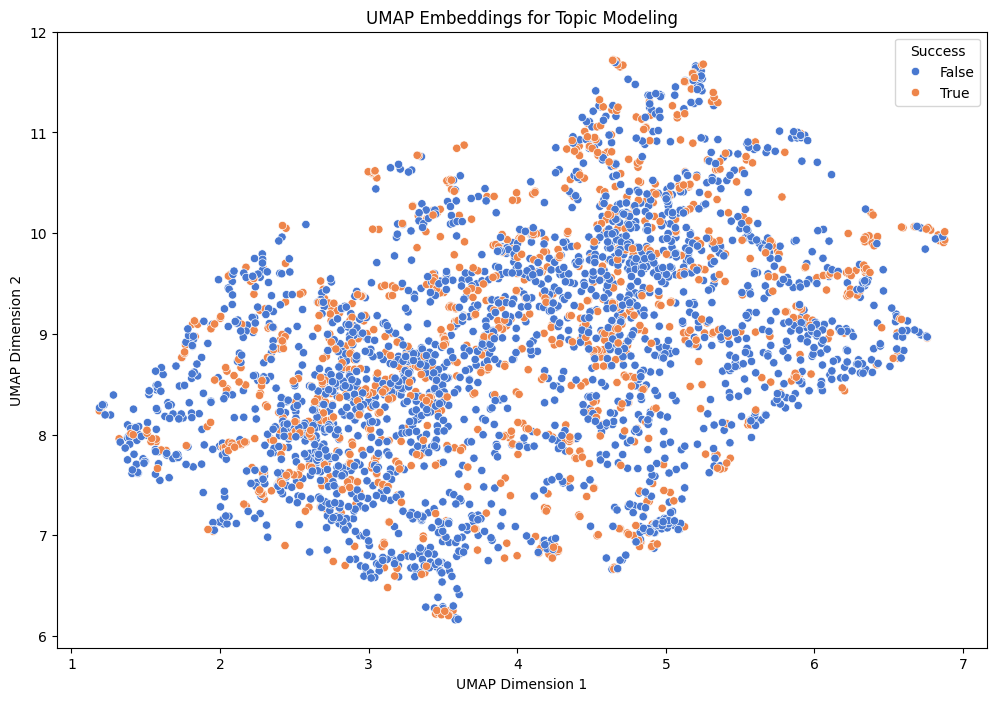

In [17]:
# Topic Modeling

# Load pre-trained sentence transformer model
sentence_transformer = SentenceTransformer("all-MiniLM-L6-v2")

# Compute sentence embeddings
embeddings = sentence_transformer.encode(df["title"].tolist())

# Reduce dimensionality with UMAP
n_components = 3
reducer = umap.UMAP(n_neighbors=15, n_components=n_components, random_state=SEED)
reducer.fit(embeddings)


def get_umap_embeddings(df):
    # define a function we can apply to test data
    embeddings = sentence_transformer.encode(df["title"].tolist())
    umap_embeddings = reducer.transform(embeddings)
    # Add UMAP embeddings to the DataFrame
    for i in range(n_components):
        df[f"umap_{i}"] = umap_embeddings[:, i]


get_umap_embeddings(df)

# Plot UMAP embeddings
plt.figure(figsize=(12, 8))
sns.scatterplot(x="umap_1", y="umap_2", hue="success", data=df, palette="muted")
plt.title("UMAP Embeddings for Topic Modeling")
plt.xlabel("UMAP Dimension 1")
plt.ylabel("UMAP Dimension 2")
plt.legend(title="Success")
plt.show()

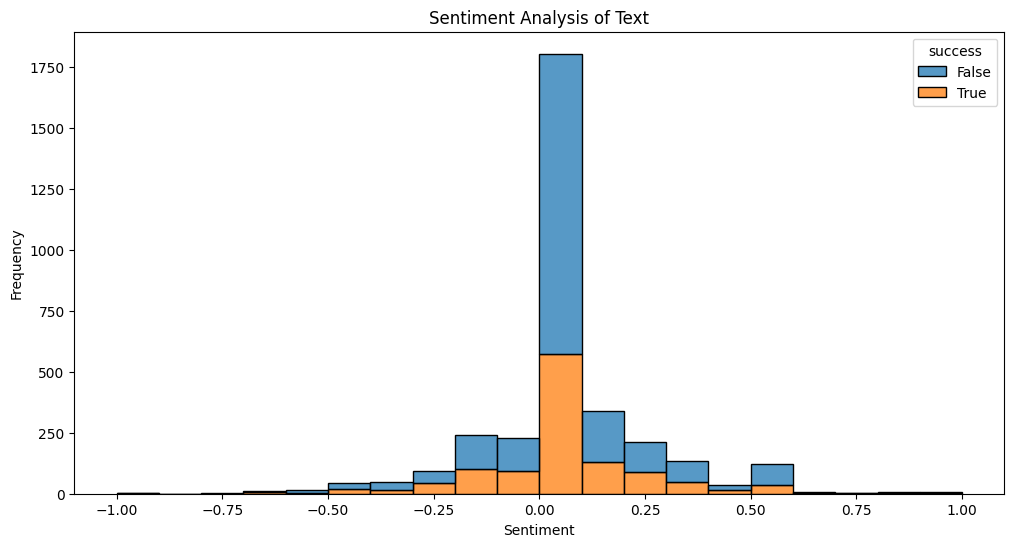

In [18]:
# Sentiment analysis with TextBlob
def get_sentiment(text):
    blob = TextBlob(text)
    return blob.sentiment.polarity


df["sentiment"] = df["title"].apply(get_sentiment)

# Plot sentiment distribution
plt.figure(figsize=(12, 6))
sns.histplot(data=df, x="sentiment", multiple="stack", bins=20, hue="success")
plt.title("Sentiment Analysis of Text")
plt.xlabel("Sentiment")
plt.ylabel("Frequency")
plt.show()

Root Mean Squared Error: 20486566.533002615
R^2 Score: 0.3185457254913354


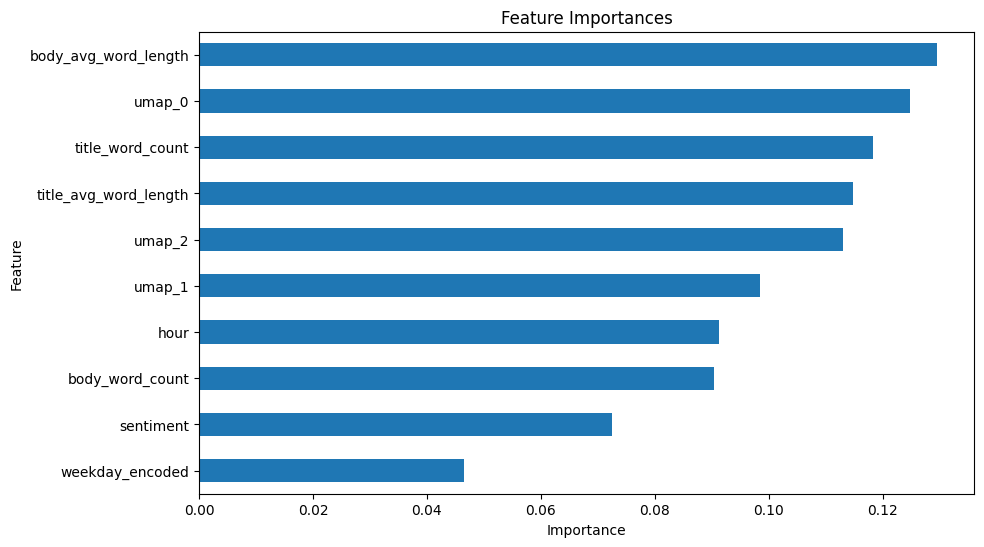

In [19]:
# apply transforms to test data
test_df["tag"] = test_df["tag"].replace("", "untagged")
time_breakdown(test_df)
get_textual_stats(test_df)
get_umap_embeddings(test_df)
test_df["sentiment"] = test_df["title"].apply(get_sentiment)
test_df["success"] = test_df["score"] >= threshold

df["weekday"] = df["weekday"].astype("category")
test_df["weekday"] = test_df["weekday"].astype("category")

weekday_encoder = LabelEncoder()
df["weekday_encoded"] = weekday_encoder.fit_transform(df["weekday"])
test_df["weekday_encoded"] = weekday_encoder.transform(test_df["weekday"])

# Selecting features and target variable
features = [
    "weekday_encoded",
    "hour",
    "sentiment",
    "title_word_count",
    "body_word_count",
    "title_avg_word_length",
    "body_avg_word_length",
] + [f"umap_{i}" for i in range(n_components)]
X_train, X_test = df[features], test_df[features]
y_train, y_test = df["score"], test_df["score"]

# Initializing and training the RandomForest Regressor
model = RandomForestRegressor(
    n_estimators=100,
    random_state=SEED,
)
model.fit(X_train, y_train)

# Making predictions
y_pred = model.predict(X_test)

# Evaluating the model
rmse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Root Mean Squared Error: {rmse}")
print(f"R^2 Score: {r2}")

# Feature importance visualization
feature_importances = pd.Series(model.feature_importances_, X_train.columns)
plt.figure(figsize=(10, 6))
feature_importances.sort_values().plot(kind="barh")
plt.title("Feature Importances")
plt.xlabel("Importance")
plt.ylabel("Feature")
plt.show()

## Results

This model is not super effective at the task of predicting score.  While it's not entirely useless, the 'score' variable is known to be very noisy in something like social media.

All of the features I extracted seem to be pulling some weight, the importances are fairly balanced.  I am a little surprised that body average word length is the highest, but this could simply be because I encoded body_average_word_count = 0 when body_word_count = 0.

With more time, I would:

- look into authors, and fit a model to historically good authors.  There's also some very easy improvements by looking at Moderators
- do a better job of assessing tags, seeing what can be pulled from new posts maybe trying to build a model to predict tag and build from there.
- gather additional data as well as features from reddit, I wanted to actually use a scraping tool called PRAW to get more data.  This also lends itself to assessing model/data drift, which will be very important when dealing with social media data and I also think would have been good to display in this project if I had more time.
- dive deeper into the text data, there is much more to grab, both basic and using more cutting edge techniques.

With that, let's not finish quite yet.  I can run a Random Forest Classifier to see if I can at least check if a post will be successful based on the heuristic I established earlier:

Accuracy: 0.7872
Precision: 0.7854
Recall: 0.7872
F1 Score: 0.7823


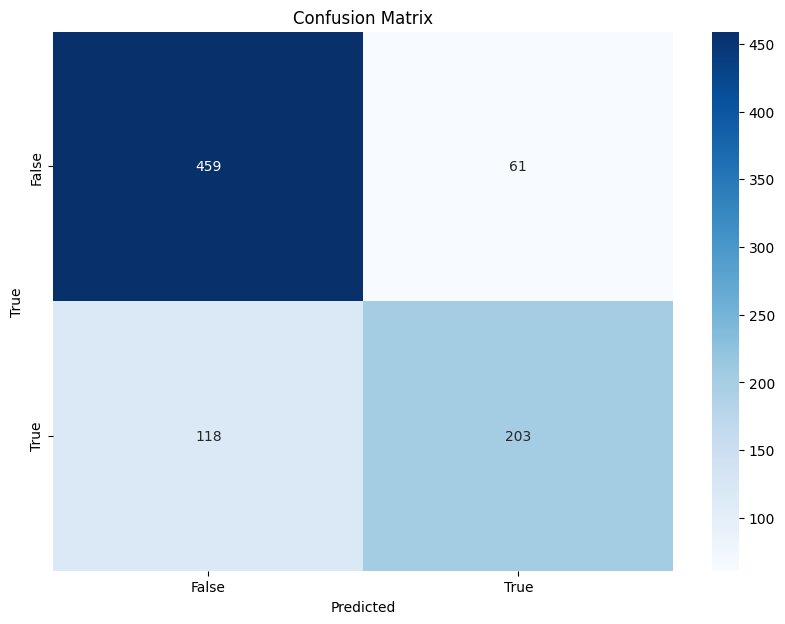

In [20]:
y_train, y_test = df["success"], test_df["success"]

# Initialize the RandomForest Classifier
clf = RandomForestClassifier(n_estimators=100, random_state=42)

# Train the classifier
clf.fit(X_train, y_train)

# Make predictions
y_pred = clf.predict(X_test)

# Calculate metrics
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average="weighted")
recall = recall_score(y_test, y_pred, average="weighted")
f1 = f1_score(y_test, y_pred, average="weighted")
conf_matrix = confusion_matrix(y_test, y_pred)

# Print metrics
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")

# Plot confusion matrix
plt.figure(figsize=(10, 7))
sns.heatmap(
    conf_matrix,
    annot=True,
    fmt="d",
    cmap="Blues",
    xticklabels=clf.classes_,
    yticklabels=clf.classes_,
)
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

Cool!  This classifier predicts if a social media post will score more than 6000 with very balanced precision/recall.  We could do better than a 0.78 F1-Score, but could also do worse.  With good balance we likely could tune the threshold well if false positives or false negatives are more important to the business need.